### Using GPR to predict Flame Length

#### Import Libraries

In [192]:
# Sys
import os
import sys
import json
sys.path.append("..")

# Data
import pandas as pd
import numpy as np
import shap
shap.initjs() 
import joblib
import importlib
from src import path
importlib.reload(path)
from src.path import PATH_DATASETV1, PATH_DATA_FLAMELENGTH, PATH_DATA_FLAMELENGTH_NEW, PATH_FLAMELENGTH_FOLDER

# Visualization
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, DotProduct, RBF

from sklearn.metrics import mean_squared_error, r2_score

# plotting defaults
%matplotlib inline

#### Functions

In [193]:
def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))

#### Load and combine FlameLength.xlsx and DatasetV1.xlsx

In [228]:
# Load
df_main = pd.read_excel(PATH_DATASETV1)
df_fl = pd.read_excel(PATH_DATA_FLAMELENGTH)

# Merge on 'Name' column
df = pd.merge(df_main, df_fl, on="Name")

# show rows present only in the flame-length file
# only_in_flame = df_fl[~df_fl['Name'].isin(df_main['Name'])].copy()
# print(len(only_in_flame), "rows only in flame-length file")
print(len(df), "rows after merge")

# display IDs
# if len(only_in_flame):
#     display(only_in_flame[['Name']].head(50))
#     only_in_flame.to_csv(os.path.join(os.path.dirname(PATH_DATA_FLAMELENGTH), "only_in_flame.csv"), index=False)


# check for duplicates in merged dataframe
col = "Name"

print("Any duplicate IDs? ", df[col].duplicated().any())
print("Duplicate count (extra rows):", df[col].duplicated().sum())

# drop exact duplicates across all columns, keep first occurrence
df = df.drop_duplicates(keep="first")
print("Rows after dropping exact duplicates:", len(df))

df = pd.read_excel(PATH_DATA_FLAMELENGTH_NEW) 
df["Z1"] /= 1000  # convert mm -> m

# Rescale 'phiint' -> phi/(1+phi) and insert new column immediately after the original

# Convert to numeric just in case (non-numeric -> NaN)
phi = pd.to_numeric(df["PhiInt"], errors="coerce")

# Compute rescaled value
phi_rescaled = phi / (1 + phi)
new_col = "PhiInt_rescaled"
# Insert new column immediately after 'phiint'
idx = df.columns.get_loc("PhiInt")
df.insert(loc=idx + 1, column=new_col, value=phi_rescaled)

display(df[["PhiInt", new_col]].head(10))

# Create binary chamber column: New = 1, Old = 0
# df["Chamber_Binary"] = (df["Chamber"] == "New").astype(int)

# Add S2/S1 ratio
df["S2/S1"] = df["S2"] / (df["S1"] + 0.01)  # avoid division by zero

# Add deltaS (always positive)
df["DeltaS"] = np.abs(df["S2"] - df["S1"])

# Convert Type column from Roman numerals to integers
# type_mapping = {"I": 1, "II": 2, "III": 3, "IV": 4}
# df["Type"] = df["Type"].map(type_mapping)

df["DeltaU/u1"] = np.abs(df["u2"] - df["u1"]) / (df["u1"])  # avoid division by zero


def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))

57 rows after merge
Any duplicate IDs?  True
Duplicate count (extra rows): 9
Rows after dropping exact duplicates: 48


,PhiInt,PhiInt_rescaled
0,2.019122,0.668778
1,1.997590,0.666399
2,1.996177,0.666241
3,1.997295,0.666366
4,2.003697,0.667077
5,2.002498,0.666944
6,2.010451,0.667824
7,2.009796,0.667752
8,2.007002,0.667443
9,2.007576,0.667506


#### Feature Selection

In [238]:
# feature and target selection
features = [
    "PhiInt_rescaled",
    "S1",
    "S2",
    "d1",
    "d2",
    "u1",
    "u2",
    "Chamber_Binary",
    "DeltaU",
    "u2/u1",
    "S2/S1",
    "DeltaS",
]

features = [
    "PhiInt_rescaled",
    "S1",
    "S2",
    "u1",
    "u2",
    "d1",
    "d2",
]

target = "Z1"  # FlameLength

X = df[features].copy()
y = df[target].copy()
print("Lf min:", y.min())
print("Lf max:", y.max())

print("Feature matrix shape:", X.shape)

Lf min: 0.014099718537575514
Lf max: 0.16503074789946928
Feature matrix shape: (192, 7)


#### Ridge Baseline - simple linear regression

In [261]:
# Ridge baseline for comparison with GPR
# StandardScaler() normalises features to mean=0, std=1
# alpha is regularization strength
pipeline_ridge = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=1.0))])
cv = KFold(n_splits=5, shuffle=True, random_state=1)  # 5-fold cross-validation
ridge_scores = -cross_val_score(
    pipeline_ridge, X, y, cv=cv, scoring="neg_root_mean_squared_error"
)
print(f"Ridge CV RMSE: mean={ridge_scores.mean():.5f}, std={ridge_scores.std():.5f}")

Ridge CV RMSE: mean=0.02305, std=0.00220


mean=0.019 : relatively low RMSE   
std=0.003 : small variance across different folds means model is not sensitive to data splits  
R2 not used, misleading with small datasets.

#### Linear Kernel GPR

In [262]:
# GPR with Linear kernel (DotProduct) + WhiteKernel
# DotProduct kernel represents linear relationships: k(x, x') = x · x'
kernel_linear = ConstantKernel(1.0, (1e-2, 1e2)) * DotProduct(
    sigma_0=1.0, sigma_0_bounds=(1e-6, 1e1)
) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-6, 1e-1))
# Pipeline
gpr_linear = GaussianProcessRegressor(
    kernel=kernel_linear, n_restarts_optimizer=8, normalize_y=True
)
pipeline_gpr_linear = Pipeline([("scaler", StandardScaler()), ("gpr", gpr_linear)])

# Cross-validated RMSE (5-fold) to ensure non-biasedness of train-test split
gpr_linear_scores = -cross_val_score(
    pipeline_gpr_linear, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=1
)
print(
    f"Linear GPR CV RMSE: mean={gpr_linear_scores.mean():.5f}, std={gpr_linear_scores.std():.5f}"
)
gpr_linear_r2 = cross_val_score(
    pipeline_gpr_linear, X, y, cv=cv, scoring="r2", n_jobs=1
)
print(
    f"Linear GPR CV R2 : mean={gpr_linear_r2.mean():.4f}, std={gpr_linear_r2.std():.4f}"
)

# Per-fold train/test diagnostics with uncertainty + coverage (Linear)
fold_metrics_linear = []
for i, (tr, te) in enumerate(cv.split(X, y), 1):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]
    pipeline_gpr_linear.fit(X_tr, y_tr)

    # use underlying GPR to get std
    X_tr_scaled = pipeline_gpr_linear.named_steps["scaler"].transform(X_tr)
    X_te_scaled = pipeline_gpr_linear.named_steps["scaler"].transform(X_te)
    y_tr_pred, y_tr_std = pipeline_gpr_linear.named_steps["gpr"].predict(
        X_tr_scaled, return_std=True
    )
    y_te_pred, y_te_std = pipeline_gpr_linear.named_steps["gpr"].predict(
        X_te_scaled, return_std=True
    )

    # per-fold test (OOF) 95% CI coverage
    lower_bound_te = y_te_pred - 1.96 * y_te_std
    upper_bound_te = y_te_pred + 1.96 * y_te_std
    within_ci_te = (y_te.values >= lower_bound_te) & (y_te.values <= upper_bound_te)
    coverage_te_95 = 100 * within_ci_te.sum() / len(y_te)

    fold_metrics_linear.append(
        {
            "fold": i,
            "train_rmse": rmse(y_tr, y_tr_pred),
            "test_rmse": rmse(y_te, y_te_pred),
            "train_r2": r2_score(y_tr, y_tr_pred),
            "test_r2": r2_score(y_te, y_te_pred),
            "test_coverage_95": coverage_te_95,
        }
    )

    # sort for smooth CI plotting
    sort_idx_tr = np.argsort(y_tr.values)
    y_tr_sorted = y_tr.values[sort_idx_tr]
    y_tr_pred_sorted = y_tr_pred[sort_idx_tr]

    sort_idx_te = np.argsort(y_te.values)
    y_te_sorted = y_te.values[sort_idx_te]
    y_te_pred_sorted = y_te_pred[sort_idx_te]
    y_te_std_sorted = y_te_std[sort_idx_te]

    # # combined train+test plot per fold
    # plt.figure(figsize=(6, 6))
    # plt.scatter(y_tr_sorted, y_tr_pred_sorted, alpha=0.7, s=50, color='blue', label="Train")
    # plt.fill_between(y_te_sorted,
    #                  y_te_pred_sorted - 1.96 * y_te_std_sorted,
    #                  y_te_pred_sorted + 1.96 * y_te_std_sorted,
    #                  alpha=0.25, color='green', label='Test 95% CI')
    # plt.scatter(y_te_sorted, y_te_pred_sorted, alpha=0.9, s=50, color='red', label="Test")

    # max_val = max(y_tr_sorted.max(), y_te_sorted.max())
    # plt.plot([0, max_val], [0, max_val], "k--", lw=2, label="1:1")
    # plt.xlabel("True FlameLength")
    # plt.ylabel("Predicted FlameLength")
    # plt.xlim(0, max_val * 1.05)
    # plt.ylim(0, max_val * 1.05)
    # plt.legend()
    # plt.title(f"Linear GPR Train+Test (fold {i}) with 95% CI")
    # plt.grid(True, alpha=0.3)
    # plt.gca().set_aspect('equal', adjustable='box')
    # plt.tight_layout()
    # plt.show()

fold_df_linear = pd.DataFrame(fold_metrics_linear)
print("Per-fold metrics (mean ± std):")
print(
    f"Train RMSE: {fold_df_linear.train_rmse.mean():.5f} ± {fold_df_linear.train_rmse.std():.5f}"
)
print(
    f"Test  RMSE: {fold_df_linear.test_rmse.mean():.5f} ± {fold_df_linear.test_rmse.std():.5f}"
)
print(
    f"Train R2 : {fold_df_linear.train_r2.mean():.5f} ± {fold_df_linear.train_r2.std():.5f}"
)
print(
    f"Test  R2 : {fold_df_linear.test_r2.mean():.5f} ± {fold_df_linear.test_r2.std():.5f}"
)
print(
    f"Test 95% CI coverage: {fold_df_linear.test_coverage_95.mean():.1f}% ± {fold_df_linear.test_coverage_95.std():.1f}%"
)

# Fit on full data and diagnostics
pipeline_gpr_linear.fit(X, y)
gpr_linear_fitted = pipeline_gpr_linear.named_steps["gpr"]
print("Fitted kernel:", gpr_linear_fitted.kernel_)
print("Log-marginal-likelihood:", gpr_linear_fitted.log_marginal_likelihood_value_)

d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the sp

Linear GPR CV RMSE: mean=0.02307, std=0.00217


d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the sp

Linear GPR CV R2 : mean=0.6427, std=0.0759


d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the sp

Per-fold metrics (mean ± std):
Train RMSE: 0.02220 ± 0.00061
Test  RMSE: 0.02307 ± 0.00243
Train R2 : 0.68914 ± 0.02338
Test  R2 : 0.64275 ± 0.08487
Test 95% CI coverage: 73.0% ± 5.4%
Fitted kernel: 0.338**2 * DotProduct(sigma_0=5.67e-05) + WhiteKernel(noise_level=0.1)
Log-marginal-likelihood: -274.21599433935273


d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


#### RBF Kernel GPR

In [263]:
# GPR with RBF kernel + WhiteKernel
# RBF kernel for smooth non-linear relationships
kernel_rbf = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(
    length_scale=1.0, length_scale_bounds=(1e-3, 1e3)
) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-6, 1e-1))

gpr_rbf = GaussianProcessRegressor(
    kernel=kernel_rbf, n_restarts_optimizer=8, normalize_y=True
)
pipeline_gpr_rbf = Pipeline([("scaler", StandardScaler()), ("gpr", gpr_rbf)])

# Cross-validated RMSE (5-fold)
gpr_rbf_scores = -cross_val_score(
    pipeline_gpr_rbf, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=1
)
print(
    f"RBF GPR CV RMSE: mean={gpr_rbf_scores.mean():.5f}, std={gpr_rbf_scores.std():.5f}"
)
gpr_rbf_r2 = cross_val_score(pipeline_gpr_rbf, X, y, cv=cv, scoring="r2", n_jobs=1)
print(f"RBF GPR CV R2 : mean={gpr_rbf_r2.mean():.4f}, std={gpr_rbf_r2.std():.4f}")

# Per-fold train/test diagnostics with uncertainty + coverage (RBF)
fold_metrics_rbf = []
for i, (tr, te) in enumerate(cv.split(X, y), 1):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]
    pipeline_gpr_rbf.fit(X_tr, y_tr)

    # use underlying GPR to get std
    X_tr_scaled = pipeline_gpr_rbf.named_steps["scaler"].transform(X_tr)
    X_te_scaled = pipeline_gpr_rbf.named_steps["scaler"].transform(X_te)
    y_tr_pred, y_tr_std = pipeline_gpr_rbf.named_steps["gpr"].predict(
        X_tr_scaled, return_std=True
    )
    y_te_pred, y_te_std = pipeline_gpr_rbf.named_steps["gpr"].predict(
        X_te_scaled, return_std=True
    )

    # per-fold test (OOF) 95% CI coverage
    lower_bound_te = y_te_pred - 1.96 * y_te_std
    upper_bound_te = y_te_pred + 1.96 * y_te_std
    within_ci_te = (y_te.values >= lower_bound_te) & (y_te.values <= upper_bound_te)
    coverage_te_95 = 100 * within_ci_te.sum() / len(y_te)

    fold_metrics_rbf.append(
        {
            "fold": i,
            "train_rmse": rmse(y_tr, y_tr_pred),
            "test_rmse": rmse(y_te, y_te_pred),
            "train_r2": r2_score(y_tr, y_tr_pred),
            "test_r2": r2_score(y_te, y_te_pred),
            "test_coverage_95": coverage_te_95,
        }
    )

    # sort for smooth CI plotting
    sort_idx_tr = np.argsort(y_tr.values)
    y_tr_sorted = y_tr.values[sort_idx_tr]
    y_tr_pred_sorted = y_tr_pred[sort_idx_tr]

    sort_idx_te = np.argsort(y_te.values)
    y_te_sorted = y_te.values[sort_idx_te]
    y_te_pred_sorted = y_te_pred[sort_idx_te]
    y_te_std_sorted = y_te_std[sort_idx_te]

    # # combined train+test plot per fold
    # plt.figure(figsize=(6, 6))
    # plt.scatter(y_tr_sorted, y_tr_pred_sorted, alpha=0.7, s=50, color='blue', label="Train")
    # plt.fill_between(y_te_sorted,
    #                  y_te_pred_sorted - 1.96 * y_te_std_sorted,
    #                  y_te_pred_sorted + 1.96 * y_te_std_sorted,
    #                  alpha=0.25, color='green', label='Test 95% CI')
    # plt.scatter(y_te_sorted, y_te_pred_sorted, alpha=0.9, s=50, color='red', label="Test")

    # max_val = max(y_tr_sorted.max(), y_te_sorted.max())
    # plt.plot([0, max_val], [0, max_val], "k--", lw=2, label="1:1")
    # plt.xlabel("True FlameLength")
    # plt.ylabel("Predicted FlameLength")
    # plt.xlim(0, max_val * 1.05)
    # plt.ylim(0, max_val * 1.05)
    # plt.legend()
    # plt.title(f"RBF GPR Train+Test (fold {i}) with 95% CI")
    # plt.grid(True, alpha=0.3)
    # plt.gca().set_aspect('equal', adjustable='box')
    # plt.tight_layout()
    # plt.show()

fold_df_rbf = pd.DataFrame(fold_metrics_rbf)
print("Per-fold metrics (mean ± std):")
print(
    f"Train RMSE: {fold_df_rbf.train_rmse.mean():.5f} ± {fold_df_rbf.train_rmse.std():.5f}"
)
print(
    f"Test  RMSE: {fold_df_rbf.test_rmse.mean():.5f} ± {fold_df_rbf.test_rmse.std():.5f}"
)
print(
    f"Train R2 : {fold_df_rbf.train_r2.mean():.5f} ± {fold_df_rbf.train_r2.std():.5f}"
)
print(f"Test  R2 : {fold_df_rbf.test_r2.mean():.5f} ± {fold_df_rbf.test_r2.std():.5f}")
print(
    f"Test 95% CI coverage: {fold_df_rbf.test_coverage_95.mean():.1f}% ± {fold_df_rbf.test_coverage_95.std():.1f}%"
)

# Fit on full data and diagnostics
pipeline_gpr_rbf.fit(X, y)
gpr_rbf_fitted = pipeline_gpr_rbf.named_steps["gpr"]
print("Fitted kernel:", gpr_rbf_fitted.kernel_)
print("Log-marginal-likelihood:", gpr_rbf_fitted.log_marginal_likelihood_value_)

d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the sp

RBF GPR CV RMSE: mean=0.02037, std=0.00591


d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the sp

RBF GPR CV R2 : mean=0.7083, std=0.1514


d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the sp

Per-fold metrics (mean ± std):
Train RMSE: 0.01078 ± 0.00155
Test  RMSE: 0.02037 ± 0.00660
Train R2 : 0.92612 ± 0.01919
Test  R2 : 0.70827 ± 0.16927
Test 95% CI coverage: 90.1% ± 7.5%
Fitted kernel: 0.883**2 * RBF(length_scale=1.04) + WhiteKernel(noise_level=0.1)
Log-marginal-likelihood: -161.39766845007804


d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


#### Linear + RBF Kernel GPR

In [305]:
# GPR with Linear + RBF kernel + WhiteKernel
# Combines linear and non-linear relationships
kernel_combined = ConstantKernel(1.0, (1e-2, 1e2)) * (
    DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-8, 1e1))
    + RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3))
) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-8, 1e-1))

gpr_combined = GaussianProcessRegressor(
    kernel=kernel_combined, n_restarts_optimizer=8, normalize_y=True
)
pipeline_gpr_combined = Pipeline([("scaler", StandardScaler()), ("gpr", gpr_combined)])

# Cross-validated RMSE (5-fold)
gpr_combined_scores = -cross_val_score(
    pipeline_gpr_combined, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=1
)
print(
    f"Linear+RBF GPR CV RMSE: mean={gpr_combined_scores.mean():.5f}, std={gpr_combined_scores.std():.5f}"
)
gpr_combined_r2 = cross_val_score(
    pipeline_gpr_combined, X, y, cv=cv, scoring="r2", n_jobs=1
)
print(
    f"Linear+RBF GPR CV R2 : mean={gpr_combined_r2.mean():.4f}, std={gpr_combined_r2.std():.4f}"
)

# Per-fold train/test diagnostics with uncertainty + coverage
fold_metrics_combined = []
for i, (tr, te) in enumerate(cv.split(X, y), 1):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]
    pipeline_gpr_combined.fit(X_tr, y_tr)

    # use underlying GPR to get std
    X_tr_scaled = pipeline_gpr_combined.named_steps["scaler"].transform(X_tr)
    X_te_scaled = pipeline_gpr_combined.named_steps["scaler"].transform(X_te)
    y_tr_pred, y_tr_std = pipeline_gpr_combined.named_steps["gpr"].predict(
        X_tr_scaled, return_std=True
    )
    y_te_pred, y_te_std = pipeline_gpr_combined.named_steps["gpr"].predict(
        X_te_scaled, return_std=True
    )

    # per-fold test (OOF) 95% CI coverage
    lower_bound_te = y_te_pred - 1.96 * y_te_std
    upper_bound_te = y_te_pred + 1.96 * y_te_std
    within_ci_te = (y_te.values >= lower_bound_te) & (y_te.values <= upper_bound_te)
    coverage_te_95 = 100 * within_ci_te.sum() / len(y_te)

    fold_metrics_combined.append(
        {
            "fold": i,
            "train_rmse": rmse(y_tr, y_tr_pred),
            "test_rmse": rmse(y_te, y_te_pred),
            "train_r2": r2_score(y_tr, y_tr_pred),
            "test_r2": r2_score(y_te, y_te_pred),
            "test_coverage_95": coverage_te_95,
        }
    )

    # sort for smooth CI plotting
    sort_idx_tr = np.argsort(y_tr.values)
    y_tr_sorted = y_tr.values[sort_idx_tr]
    y_tr_pred_sorted = y_tr_pred[sort_idx_tr]

    sort_idx_te = np.argsort(y_te.values)
    y_te_sorted = y_te.values[sort_idx_te]
    y_te_pred_sorted = y_te_pred[sort_idx_te]
    y_te_std_sorted = y_te_std[sort_idx_te]

    # # combined train+test plot per fold
    # plt.figure(figsize=(6, 6))
    # plt.scatter(y_tr_sorted, y_tr_pred_sorted, alpha=0.7, s=50, color='blue', label="Train")
    # plt.fill_between(y_te_sorted,
    #                  y_te_pred_sorted - 1.96 * y_te_std_sorted,
    #                  y_te_pred_sorted + 1.96 * y_te_std_sorted,
    #                  alpha=0.25, color='green', label='Test 95% CI')
    # plt.scatter(y_te_sorted, y_te_pred_sorted, alpha=0.9, s=50, color='red', label="Test")

    # max_val = max(y_tr_sorted.max(), y_te_sorted.max())
    # plt.plot([0, max_val], [0, max_val], "k--", lw=2, label="1:1")
    # plt.xlabel("True FlameLength")
    # plt.ylabel("Predicted FlameLength")
    # plt.xlim(0, max_val * 1.05)
    # plt.ylim(0, max_val * 1.05)
    # plt.legend()
    # plt.title(f"Linear+RBF GPR Train+Test (fold {i}) with 95% CI")
    # plt.grid(True, alpha=0.3)
    # plt.gca().set_aspect('equal', adjustable='box')
    # plt.tight_layout()
    # plt.show()

fold_df_combined = pd.DataFrame(fold_metrics_combined)
print("Per-fold metrics (mean ± std):")
print(
    f"Train RMSE: {fold_df_combined.train_rmse.mean():.5f} ± {fold_df_combined.train_rmse.std():.5f}"
)
print(
    f"Test  RMSE: {fold_df_combined.test_rmse.mean():.5f} ± {fold_df_combined.test_rmse.std():.5f}"
)
print(
    f"Train R2 : {fold_df_combined.train_r2.mean():.5f} ± {fold_df_combined.train_r2.std():.5f}"
)
print(
    f"Test  R2 : {fold_df_combined.test_r2.mean():.5f} ± {fold_df_combined.test_r2.std():.5f}"
)
print(
    f"Test 95% CI coverage: {fold_df_combined.test_coverage_95.mean():.1f}% ± {fold_df_combined.test_coverage_95.std():.1f}%"
)

# Calculate average CI interval width per fold
ci_widths = []
for i, (tr, te) in enumerate(cv.split(X, y)):
    X_te_scaled = pipeline_gpr_combined.named_steps["scaler"].transform(X.iloc[te])
    _, y_te_std = pipeline_gpr_combined.named_steps["gpr"].predict(
        X_te_scaled, return_std=True
    )
    ci_width = 2 * 1.96 * y_te_std.mean()  # avg interval width (±1.96σ)
    ci_widths.append(ci_width)

print(
    f"Avg 95% CI interval width: {np.mean(ci_widths):.5f} ± {np.std(ci_widths):.5f}"
)

# Fit on full data and diagnostics
pipeline_gpr_combined.fit(X, y)
gpr_combined_fitted = pipeline_gpr_combined.named_steps["gpr"]
print("Fitted kernel:", gpr_combined_fitted.kernel_)
print("Log-marginal-likelihood:", gpr_combined_fitted.log_marginal_likelihood_value_)

d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the sp

Linear+RBF GPR CV RMSE: mean=0.02000, std=0.00522


d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__sigma_0 is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to 

Linear+RBF GPR CV R2 : mean=0.7238, std=0.1239


d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the sp

Per-fold metrics (mean ± std):
Train RMSE: 0.01056 ± 0.00146
Test  RMSE: 0.02000 ± 0.00583
Train R2 : 0.92920 ± 0.01747
Test  R2 : 0.72385 ± 0.13848
Test 95% CI coverage: 90.6% ± 7.8%
Avg 95% CI interval width: 0.06132 ± 0.00330
Fitted kernel: 0.515**2 * DotProduct(sigma_0=0.000145) + RBF(length_scale=0.706) + WhiteKernel(noise_level=0.1)
Log-marginal-likelihood: -153.83826258068405


d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


#### Matern Kernel GPR

In [306]:
# GPR with Matern (ARD) + WhiteKernel; use ARD by passing a vector length_scale
kernel_matern = ConstantKernel(1.0, (1e-2, 1e2)) * Matern(
    length_scale=np.ones(X.shape[1]), length_scale_bounds=(1e-3, 1e8), nu=2.5
) + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-6, 1e1))

gpr_matern = GaussianProcessRegressor(
    kernel=kernel_matern, n_restarts_optimizer=8, normalize_y=True
)
pipeline_gpr_matern = Pipeline([("scaler", StandardScaler()), ("gpr", gpr_matern)])

# Cross-validated RMSE (5-fold)
gpr_matern_scores = -cross_val_score(
    pipeline_gpr_matern, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=1
)
print(
    f"Matern GPR CV RMSE: mean={gpr_matern_scores.mean():.5f}, std={gpr_matern_scores.std():.5f}"
)
gpr_matern_r2 = cross_val_score(
    pipeline_gpr_matern, X, y, cv=cv, scoring="r2", n_jobs=1
)
print(
    f"Matern GPR CV R2 : mean={gpr_matern_r2.mean():.4f}, std={gpr_matern_r2.std():.4f}"
)

# Per-fold train/test diagnostics
fold_metrics_matern = []
for i, (tr, te) in enumerate(cv.split(X, y), 1):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]
    pipeline_gpr_matern.fit(X_tr, y_tr)

    # use underlying GPR to get std
    X_tr_scaled = pipeline_gpr_matern.named_steps["scaler"].transform(X_tr)
    X_te_scaled = pipeline_gpr_matern.named_steps["scaler"].transform(X_te)
    y_tr_pred, y_tr_std = pipeline_gpr_matern.named_steps["gpr"].predict(
        X_tr_scaled, return_std=True
    )
    y_te_pred, y_te_std = pipeline_gpr_matern.named_steps["gpr"].predict(
        X_te_scaled, return_std=True
    )

    # per-fold test (OOF) 95% CI coverage
    lower_bound_te = y_te_pred - 1.96 * y_te_std
    upper_bound_te = y_te_pred + 1.96 * y_te_std
    within_ci_te = (y_te.values >= lower_bound_te) & (y_te.values <= upper_bound_te)
    coverage_te_95 = 100 * within_ci_te.sum() / len(y_te)

    fold_metrics_matern.append(
        {
            "fold": i,
            "train_rmse": rmse(y_tr, y_tr_pred),
            "test_rmse": rmse(y_te, y_te_pred),
            "train_r2": r2_score(y_tr, y_tr_pred),
            "test_r2": r2_score(y_te, y_te_pred),
            "test_coverage_95": coverage_te_95,
        }
    )

    # sort for smooth CI plotting
    sort_idx_tr = np.argsort(y_tr.values)
    y_tr_sorted = y_tr.values[sort_idx_tr]
    y_tr_pred_sorted = y_tr_pred[sort_idx_tr]
    y_tr_std_sorted = y_tr_std[sort_idx_tr]

    sort_idx_te = np.argsort(y_te.values)
    y_te_sorted = y_te.values[sort_idx_te]
    y_te_pred_sorted = y_te_pred[sort_idx_te]
    y_te_std_sorted = y_te_std[sort_idx_te]

    # # combined train+test plot per fold
    # plt.figure(figsize=(6, 6))
    # # train CI + points
    # plt.scatter(y_tr_sorted, y_tr_pred_sorted, alpha=0.7, s=50, color='blue', label="Train")
    # # test CI + points
    # plt.fill_between(y_te_sorted,
    #                  y_te_pred_sorted - 1.96 * y_te_std_sorted,
    #                  y_te_pred_sorted + 1.96 * y_te_std_sorted,
    #                  alpha=0.25, color='green', label='Test 95% CI')
    # plt.scatter(y_te_sorted, y_te_pred_sorted, alpha=0.9, s=50, color='red', label="Test")

    # max_val = max(y_tr_sorted.max(), y_te_sorted.max())
    # plt.plot([0, max_val], [0, max_val], "k--", lw=2, label="1:1")
    # plt.xlabel("True FlameLength")
    # plt.ylabel("Predicted FlameLength")
    # plt.xlim(0, max_val * 1.05)
    # plt.ylim(0, max_val * 1.05)
    # plt.legend()
    # plt.title(f"Matern GPR Train+Test (fold {i}) with 95% CI")
    # plt.grid(True, alpha=0.3)
    # plt.gca().set_aspect('equal', adjustable='box')
    # plt.tight_layout()
    # plt.show()

fold_df_matern = pd.DataFrame(fold_metrics_matern)
print("Per-fold metrics (mean ± std):")
print(
    f"Train RMSE: {fold_df_matern.train_rmse.mean():.5f} ± {fold_df_matern.train_rmse.std():.5f}"
)
print(
    f"Test  RMSE: {fold_df_matern.test_rmse.mean():.5f} ± {fold_df_matern.test_rmse.std():.5f}"
)
print(
    f"Train R2 : {fold_df_matern.train_r2.mean():.5f} ± {fold_df_matern.train_r2.std():.5f}"
)
print(
    f"Test  R2 : {fold_df_matern.test_r2.mean():.5f} ± {fold_df_matern.test_r2.std():.5f}"
)
print(
    f"Test 95% CI coverage: {fold_df_matern.test_coverage_95.mean():.1f}% ± {fold_df_matern.test_coverage_95.std():.1f}%"
)

# Calculate average CI interval width per fold
ci_widths = []
for i, (tr, te) in enumerate(cv.split(X, y)):
    X_te_scaled = pipeline_gpr_matern.named_steps["scaler"].transform(X.iloc[te])
    _, y_te_std = pipeline_gpr_matern.named_steps["gpr"].predict(
        X_te_scaled, return_std=True
    )
    ci_width = 2 * 1.96 * y_te_std.mean()  # avg interval width (±1.96σ)
    ci_widths.append(ci_width)

print(
    f"Avg 95% CI interval width: {np.mean(ci_widths):.5f} ± {np.std(ci_widths):.5f}"
)


# Fit on full data and diagnostics
pipeline_gpr_matern.fit(X, y)
gpr_matern_fitted = pipeline_gpr_matern.named_steps["gpr"]
print("Fitted kernel:", gpr_matern_fitted.kernel_)
print("Log-marginal-likelihood:", gpr_matern_fitted.log_marginal_likelihood_value_)

Matern GPR CV RMSE: mean=0.01952, std=0.00451
Matern GPR CV R2 : mean=0.7390, std=0.0971
Per-fold metrics (mean ± std):
Train RMSE: 0.01355 ± 0.00275
Test  RMSE: 0.01952 ± 0.00504
Train R2 : 0.88127 ± 0.04504
Test  R2 : 0.73902 ± 0.10860
Test 95% CI coverage: 90.1% ± 8.6%
Avg 95% CI interval width: 0.07739 ± 0.00056
Fitted kernel: 0.999**2 * Matern(length_scale=[6.83, 1.19, 2.41, 1.22e+04, 4.89, 4.02, 2.34], nu=2.5) + WhiteKernel(noise_level=0.158)
Log-marginal-likelihood: -141.9242701071383


In [266]:
# save cleaned merged data and trained pipeline
# out_csv = os.path.join(os.path.dirname(PATH_DATASETV1), "merged_cleaned_with_flame.csv")
# df.to_csv(out_csv, index=False)
# print("Saved merged data to", out_csv)

# model_path = os.path.join(PATH_FLAMELENGTH_FOLDER, "gpr_pipeline_matern.joblib")
# joblib.dump(pipeline_gpr_matern, model_path)
# print("Saved Matern GPR pipeline to", model_path)

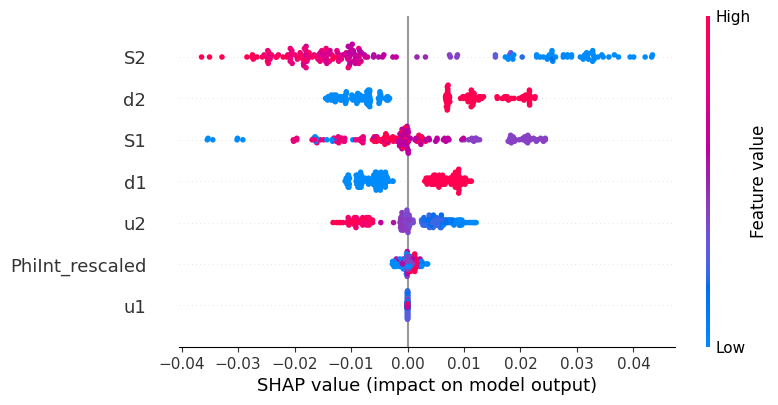

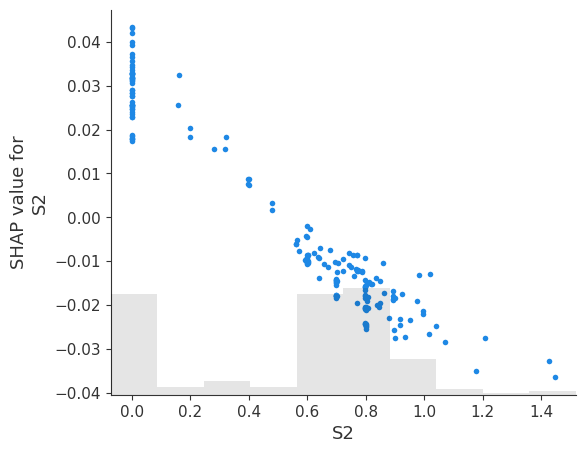

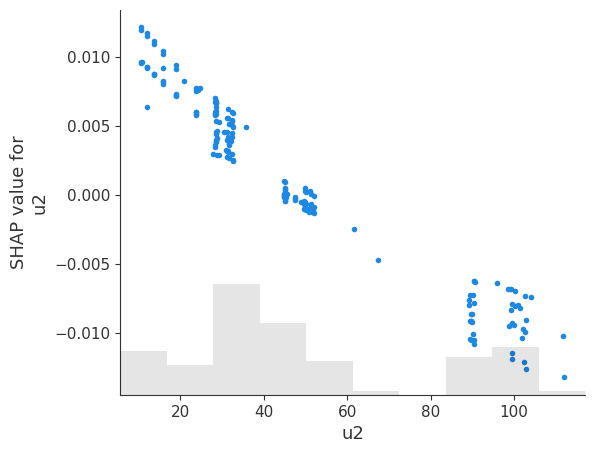

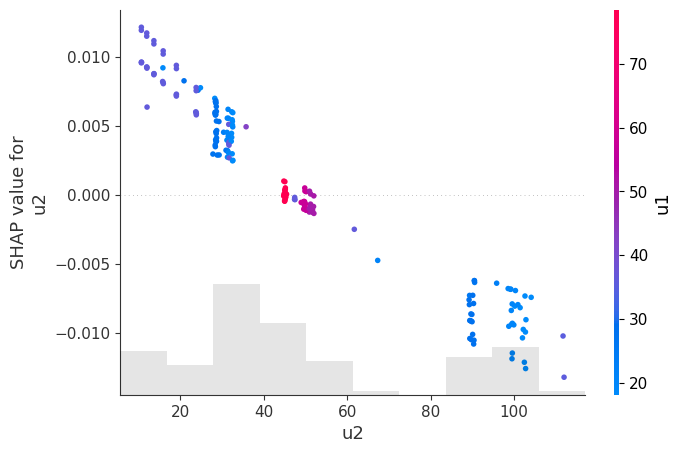

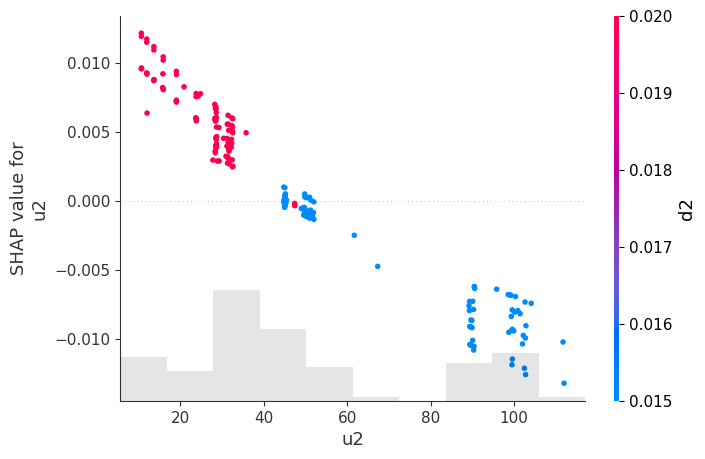

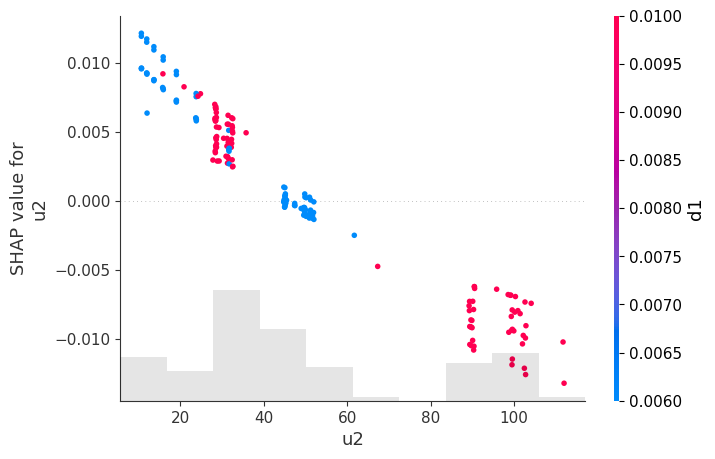

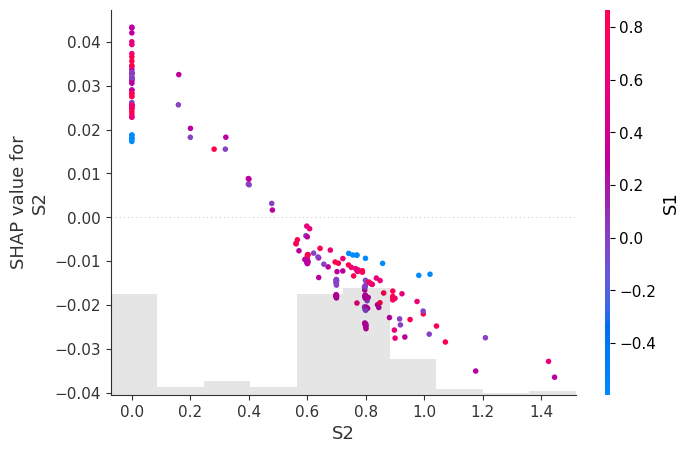

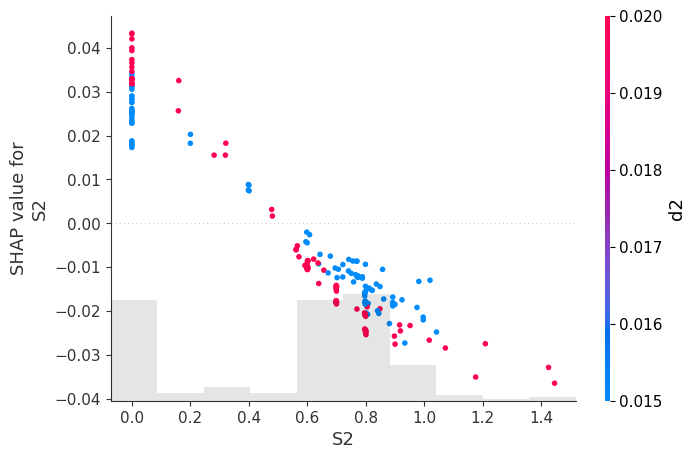

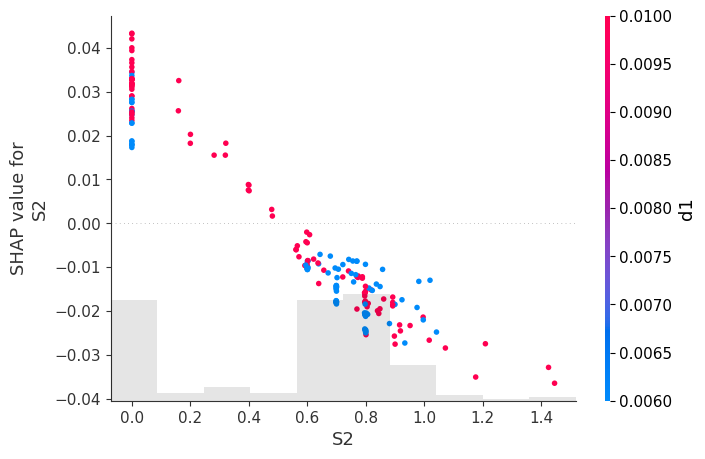

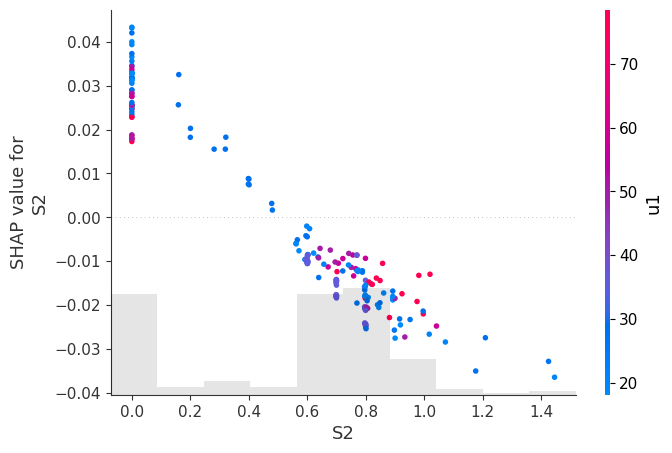

In [310]:
# model = callable that predicts with the full pipeline
model = lambda X_in: pipeline_gpr_matern.predict(
    pd.DataFrame(X_in, columns=X.columns)
)

# use DataFrames to preserve feature names
X_bg_df = X.sample(n=min(50, len(X)), random_state=42)
X_explain_df = X.sample(n=min(200, len(X)), random_state=24)

explainer = shap.Explainer(model, X_bg_df)  # KernelExplainer under the hood
shap_values = explainer(X_explain_df)

shap.plots.beeswarm(shap_values, max_display=20)
# shap.plots.bar(shap_values)
shap.plots.scatter(shap_values[:, "S2"])
shap.plots.scatter(shap_values[:, "u2"])

# Dependence plots
shap.plots.scatter(shap_values[:, "u2"], color=shap_values[:, "u1"])
shap.plots.scatter(shap_values[:, "u2"], color=shap_values[:, "d2"])
shap.plots.scatter(shap_values[:, "u2"], color=shap_values[:, "d1"])
shap.plots.scatter(shap_values[:, "S2"], color=shap_values[:, "S1"])
shap.plots.scatter(shap_values[:, "S2"], color=shap_values[:, "d2"])
shap.plots.scatter(shap_values[:, "S2"], color=shap_values[:, "d1"])

shap.plots.scatter(shap_values[:, "S2"], color=shap_values[:, "u1"])

In [309]:
shap.plots.force(shap_values)